In [11]:
# set the backend in your code at the top of your script
import os

os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from zea import init_device, File
from tqdm import trange
import zea

In [ ]:
device = init_device()
#Here i am using a multistatic acquisition that is demodulated and downsampled
file_path = "/zea/1460.hdf5"
file = File(file_path)
data = file.load_data(data_type="raw_data")

xlims = (-20e-3, 20e-3)
zlims = (0e-3, 40e-3)
width, height = xlims[1] - xlims[0], zlims[1] - zlims[0]
probe = file.probe()
wavelength = 1460 / probe.center_frequency
Nx = int(width / (0.5 * wavelength)) + 1
Nz = int(height / (0.5 * wavelength)) + 1
Nx_sample = 50
Nz_sample = 50

scan = file.scan(xlims=xlims, zlims=zlims, grid_size_x=Nx_sample, grid_size_z=Nz_sample)


def create_pipeline(loss_function):
    pipeline = zea.Pipeline(
        [
            zea.ops.PatchedGrid(
                [zea.ops.TOFCorrection(), loss_function], num_patches=Nz_sample * Nx_sample
            ),
        ],
        jit_options="pipeline",
    )
    return pipeline


pipelinepe = create_pipeline(zea.ops.PhaseError())
pipelinesb = create_pipeline(zea.ops.SpeckleBrightness())
pipelinecc = create_pipeline(zea.ops.CorrelationCoefficient())
scan.initial_times = np.zeros(scan.n_tx)  # override initial times from file
scan.polar_angles = np.zeros(scan.n_tx)  # override polar angles from file
parameters = pipelinepe.prepare_parameters(probe, scan)
parameters["f_number"] = 0.5  # right now we only have fnum masking in receive,
# for multistatic it makes sense to also have fnum masking in transmit

-------------------GPU settings-------------------
0.0 GPUs were disabled
     memory
GPU        
0         200
Selecting 1 GPU based on available memory.
Selected GPU 0 with Free Memory: 200.00 MiB
--------------------------------------------------


In [14]:
pe_list = []
cc_list = []
sb_list = []
for i in trange(1440, 1481, 1):
    parameters["sound_speed"] = i
    inputs = {"data": data, **parameters}
    pe = np.nanmean(pipelinepe(**inputs)["data"])
    sb = np.nanmean(pipelinesb(**inputs)["data"])
    cc = np.nanmean(pipelinecc(**inputs)["data"])
    pe_list.append(pe)
    cc_list.append(cc)
    sb_list.append(sb)

100%|██████████| 41/41 [00:21<00:00,  1.94it/s]


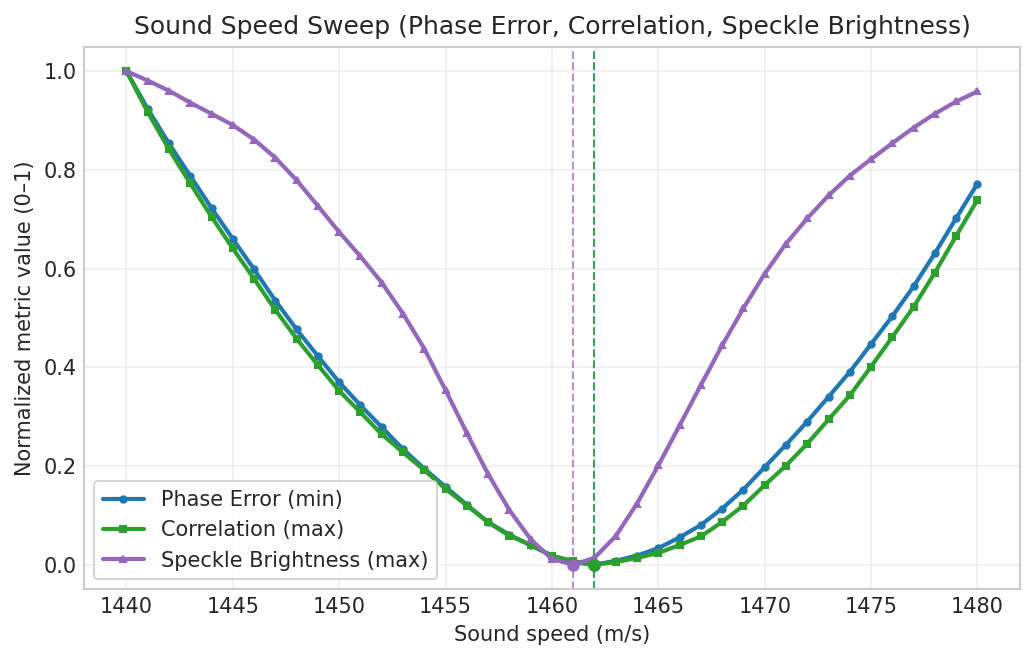

In [ ]:
sound_speeds = np.arange(1440, 1481, 1)
pe_arr = np.asarray(pe_list, dtype=float)
cc_arr = np.asarray(cc_list, dtype=float)
sb_arr = np.asarray(sb_list, dtype=float)

plt.style.use("seaborn-v0_8-whitegrid")

metrics = {
    "Phase Error (min)": {
        "values": pe_arr,
        "argbest": np.nanargmin,
        "color": "#1f77b4",
        "marker": "o",
    },
    "Correlation (max)": {
        "values": cc_arr,
        "argbest": np.nanargmin,
        "color": "#2ca02c",
        "marker": "s",
    },
    "Speckle Brightness (max)": {
        "values": sb_arr,
        "argbest": np.nanargmin,
        "color": "#9467bd",
        "marker": "^",
    },
}

fig, ax = plt.subplots(figsize=(7, 4.5), dpi=150)


def _norm(v):
    v = np.asarray(v, float)
    rng = np.nanmax(v) - np.nanmin(v)
    return (v - np.nanmin(v)) / rng if rng > 0 else np.zeros_like(v)


handles = []
for name, cfg in metrics.items():
    v = cfg["values"]
    v_norm = _norm(v)
    idx = int(cfg["argbest"](v))
    x_best = sound_speeds[idx]
    y_best = v_norm[idx]
    h = ax.plot(
        sound_speeds, v_norm, lw=2, marker=cfg["marker"], ms=3, color=cfg["color"], label=name
    )[0]
    handles.append(h)
    ax.axvline(x_best, color=cfg["color"], ls="--", lw=1, alpha=0.7)
    ax.scatter([x_best], [y_best], color=cfg["color"], zorder=5, s=25)

ax.set_xlabel("Sound speed (m/s)")
ax.set_ylabel("Normalized metric value (0–1)")
ax.set_title("Sound Speed Sweep (Phase Error, Correlation, Speckle Brightness)")
ax.legend(handles=handles, frameon=True)
ax.grid(alpha=0.3)
fig.tight_layout()